In [1]:
!pip uninstall mtcnn
!pip install mtcnn
!pip install --upgrade joblib
!pip install --upgrade lz4
# import lz4

DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/cebdict-2.1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/cebdict-2.1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 288.9 kB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 1.6 MB/s eta 0:00:001.7 MB/s eta 0:00:01
  Attempting uninstall: lz4
    Found existing installation: lz4 4.3.2
    Uninstalling lz4-4.3.2:
      Successfully uninstalled lz4-4.3.2
DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/cebdict-2.1-py3.

In [2]:
import tensorflow as tf
import lz4
import os
import cv2
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from numpy import asarray
from PIL import Image
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from mtcnn.mtcnn import MTCNN # if you encounter the error 'No module named mtcnn', execute the following command !pip install mtcnn


In [4]:
# Set parameters
IMAGE_SIZE = (128, 128)  # Resize images to 128x128
BATCH_SIZE = 32
EPOCHS = 10
# DATA_DIR = "drive/MyDrive/PERSONAL/LECTURES/MACHINE LEARNING/IMAGE CLASSIFICATION/data/image_classification_dataset"  # Update with the path to your dataset§
DATA_DIR = "/Users/ericjohnemberda/Pictures/image_classification_dataset"

In [5]:
# draw an image with detected objects
def draw_image_with_boxes(filename, result_list):
  # load the image
  data = pyplot.imread(filename)
  # plot the image
  pyplot.imshow(data)
  # get the context for drawing boxes
  ax = pyplot.gca()
  # plot each box
  for result in result_list:
    # get coordinates
    x, y, width, height = result['box']
    # create the shape
    rect = Rectangle((x, y), width, height, fill=False, color='red')
    # draw the box
    ax.add_patch(rect)

  # draw the dots (for eyes, nose, and mouth)
  for key, value in result['keypoints'].items():
    # create and draw dot
    dot = Circle(value, radius=2, color='red')
    ax.add_patch(dot)

In [6]:
# Source: https://www.sitepoint.com/keras-face-detection-recognition/
def extract_face_from_image(image_path, required_size=(128, 128)):
  # load image and detect faces
  image = pyplot.imread(image_path)
  detector = MTCNN()
  faces = detector.detect_faces(image)

  face_images = []

  for face in faces:
    # extract the bounding box from the requested face
    x1, y1, width, height = face['box']
    x2, y2 = x1 + width, y1 + height

    # extract the face
    face_boundary = image[y1:y2, x1:x2]

    # resize pixels to the model size
    face_image = Image.fromarray(face_boundary)
    face_image = face_image.resize(required_size)
    face_array = asarray(face_image)
    face_images.append(face_array)

  return face_images

In [7]:
# Load and preprocess data
def load_data(data_dir):
    image_data = []
    labels = []
    class_names = os.listdir(data_dir)

    for idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)



            # img = tf.keras.utils.load_img(img_path, target_size=IMAGE_SIZE)

            # load image from file
            pixels = pyplot.imread(img_path)
            # create the detector, using default weights
            detector = MTCNN()
            # detect faces in the image
            faces = detector.detect_faces(pixels)
            # display faces on the original image
            draw_image_with_boxes(img_path, faces)
            extracted_face = extract_face_from_image(img_path)

            img_array = tf.keras.utils.img_to_array(cv2.resize(extracted_face[0],(128,128))) #get the first image. previously just img
            image_data.append(img_array)
            labels.append(idx)

    image_data = tf.convert_to_tensor(image_data) / 255.0  # Normalize images

    labels = tf.convert_to_tensor(labels)
    return image_data, labels, class_names


Loading data...
Classes: ['tom', 'eric', 'robert']


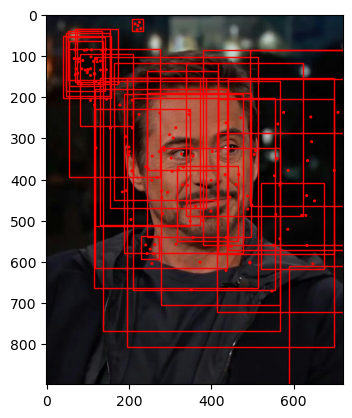

In [9]:
print("Loading data...")
image_data, labels, class_names = load_data(DATA_DIR)
print(f"Classes: {class_names}")

# if you encounter the error, LZ4 is not installed. Install it with pip: https://python-lz4.readthedocs.io/, !pip install LZ4

In [10]:
labels

<tf.Tensor: shape=(30,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)>

In [11]:
image_data[0]

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.3137255 , 0.2       , 0.15294118],
        [0.30588236, 0.1882353 , 0.15294118],
        [0.24705882, 0.15294118, 0.1254902 ],
        ...,
        [0.23529412, 0.15294118, 0.10980392],
        [0.23137255, 0.13333334, 0.09019608],
        [0.2       , 0.11372549, 0.07843138]],

       [[0.2509804 , 0.16078432, 0.11764706],
        [0.22352941, 0.14117648, 0.10588235],
        [0.16862746, 0.11764706, 0.09803922],
        ...,
        [0.21568628, 0.14117648, 0.09411765],
        [0.24705882, 0.15686275, 0.09803922],
        [0.2509804 , 0.16078432, 0.10588235]],

       [[0.21176471, 0.15294118, 0.11372549],
        [0.17254902, 0.12941177, 0.10196079],
        [0.15294118, 0.1254902 , 0.09803922],
        ...,
        [0.2509804 , 0.1882353 , 0.14509805],
        [0.19607843, 0.11764706, 0.06666667],
        [0.22352941, 0.14509805, 0.09803922]],

       ...,

       [[0.32941177, 0.38431373, 0.4627451 ],
        [0.27

In [12]:
# Split into train and validation sets
# Convert TensorFlow tensors to NumPy arrays before using train_test_split
image_data_np = image_data.numpy()
labels_np = labels.numpy()

In [13]:
# Split into train and validation sets
# X_train, X_val, y_train, y_val = train_test_split(image_data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(image_data_np, labels_np, test_size=0.2, random_state=42)



In [14]:
# Define the CNN model
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(class_names), activation='softmax')
    ])
    return model

In [15]:

model = create_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
# Train the model
BATCH_SIZE = 10
EPOCHS = 20
print("Training the model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

Training the model...
Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 0.0228 - val_accuracy: 0.8333 - val_loss: 0.7084
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.6667 - val_loss: 0.6687
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.8333 - val_loss: 0.6696
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 4.1646e-04 - val_accuracy: 0.8333 - val_loss: 0.8059
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 2.0952e-04 - val_accuracy: 0.8333 - val_loss: 0.9590
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 1.3830e-04 - val_accuracy: 0.8333 - val_loss: 0.9162
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 1.0153e-04 - val_accuracy: 0.8333 - val_loss: 0.7647
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 2.7829e-04

In [24]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8333 - loss: 0.6313
Validation Accuracy: 0.83


In [25]:

# Save the model
model.save("person_classifier_model.h5")
print("Model saved as person_classifier_model.h5")

Model saved as person_classifier_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted class: tom


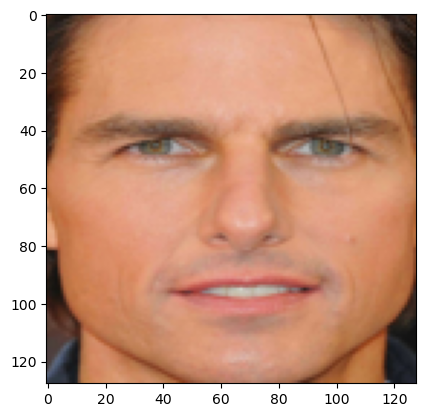

In [26]:
 # Add a batch dimension to use it with the model
pyplot.imshow(image_data_np[0])
image_array = np.expand_dims(image_data_np[0], axis=0)
prediction = model.predict(image_array)
print("Predicted class:", class_names[np.argmax(prediction)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted class: eric


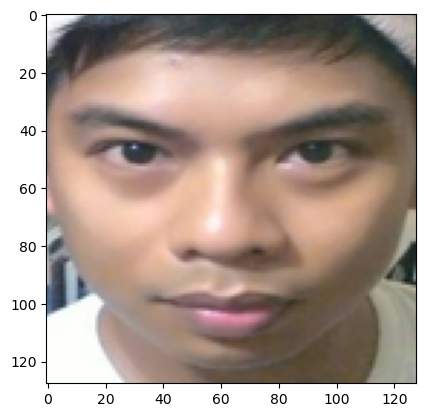

In [27]:
 # Add a batch dimension to use it with the model
pyplot.imshow(image_data_np[11])
image_array = np.expand_dims(image_data_np[11], axis=0)
prediction = model.predict(image_array)
print("Predicted class:", class_names[np.argmax(prediction)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted class: robert


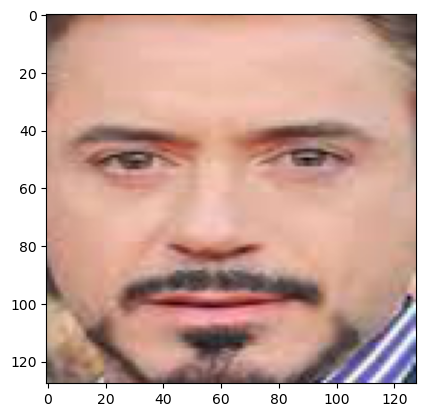

In [28]:
 # Add a batch dimension to use it with the model
pyplot.imshow(image_data_np[22])
image_array = np.expand_dims(image_data_np[22], axis=0)
prediction = model.predict(image_array)
print("Predicted class:", class_names[np.argmax(prediction)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted class: tom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted class: tom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted class: tom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted class: tom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted class: tom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted class: tom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted class: tom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted class: tom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted class: robert
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted class: tom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted class: eric
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted class: eric
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted class: eric
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted class: eric
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted class: eric
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted class: eric
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted

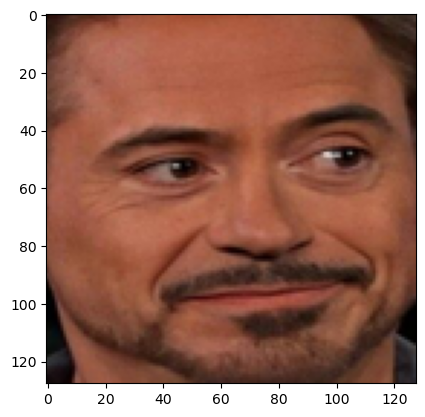

In [29]:
for i in image_data_np:
    pyplot.imshow(i)
    image_array = np.expand_dims(i, axis=0)
    prediction = model.predict(image_array)
    print("Predicted class:", class_names[np.argmax(prediction)])